# Secure AI MNIST: Assignment Notebook

Run this notebook to train the baseline CNN, generate adversarial and poisoned data, defend with adversarial training, and summarize metrics/plots for presentation.

# Imports, Seeds, and Global Config

In [1]:
import os, json, time, math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import tensorflow as tf

from tensorflow.keras import layers, models  # type: ignore
from sklearn.metrics import confusion_matrix

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer

np.random.seed(42)
tf.random.set_seed(42)

/Users/kartekeyaan/Chonky_folder/Security_MNIST_project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kartekeyaan/Chonky_folder/Security_MNIST_project/.venv/lib/python3.9/site-packages/art/estimators/certification/__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


# Paths and Hyperparameters


In [2]:
CWD = Path.cwd().resolve()
BASE_DIR = CWD
OUT_DIR   = BASE_DIR / "secure_ai_outputs"
IMG_DIR   = OUT_DIR / "images"
MODEL_DIR = OUT_DIR / "models"
METRIC_DIR= OUT_DIR / "metrics"
for d in (OUT_DIR, IMG_DIR, MODEL_DIR, METRIC_DIR):
    d.mkdir(parents=True, exist_ok=True)

print("[INFO] TensorFlow version:", tf.__version__)
print("[INFO] Images ->", IMG_DIR)
print("[INFO] Models ->", MODEL_DIR)

USE_EXISTING_MODELS = False
BASELINE_EPOCHS = 5
ADV_TRAIN_EPOCHS = 5
POISON_EPOCHS = 5
BATCH_SIZE = 128
FGSM_EPS = 0.25
PATCH_SIZE = 4
PATCH_VALUE = 1.0
TARGET_CLASS = 7


[INFO] TensorFlow version: 2.20.0
[INFO] Images -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/images
[INFO] Models -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/models


# Helper Functions (I/O, plotting, metrics)


In [3]:
def save_json(path: Path, data: dict):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(data, f, indent=2)
    print(f"[INFO] Saved JSON -> {path}")

def load_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = (x_train.astype("float32") / 255.0)[..., None]
    x_test  = (x_test.astype("float32") / 255.0)[..., None]
    return x_train, y_train, x_test, y_test

def build_cnn(input_shape=(28,28,1), num_classes=10)->tf.keras.Model:
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32,(3,3),activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,(3,3),activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128,activation="relu"),
        layers.Dense(num_classes,activation="softmax"),
    ])
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def plot_confusion_matrix(cm, title: str, save_path: Path):
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                xticklabels=list(range(10)), yticklabels=list(range(10)))
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    fig.tight_layout(); fig.savefig(save_path, bbox_inches="tight")
    plt.show(); plt.close(fig)
    print(f"[INFO] Saved confusion matrix -> {save_path}")

def plot_history(history, acc_path: Path, loss_path: Path):
    if history is None: return
    h = history.history
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(h["accuracy"], label="train_acc")
    if "val_accuracy" in h: ax.plot(h["val_accuracy"], label="val_acc")
    ax.set_title("Accuracy"); ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy"); ax.legend()
    fig.tight_layout(); fig.savefig(acc_path, bbox_inches="tight")
    plt.show(); plt.close(fig); print(f"[INFO] Saved accuracy plot -> {acc_path}")

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(h["loss"], label="train_loss")
    if "val_loss" in h: ax.plot(h["val_loss"], label="val_loss")
    ax.set_title("Loss"); ax.set_xlabel("Epoch"); ax.set_ylabel("Loss"); ax.legend()
    fig.tight_layout(); fig.savefig(loss_path, bbox_inches="tight")
    plt.show(); plt.close(fig); print(f"[INFO] Saved loss plot -> {loss_path}")

def evaluate_model(model: tf.keras.Model, x, y):
    loss, acc = model.evaluate(x, y, verbose=0)
    y_pred = np.argmax(model.predict(x, verbose=0), axis=1)
    cm = confusion_matrix(y, y_pred)
    return float(loss), float(acc), cm

def measure_inference_time(model: tf.keras.Model, x):
    start = time.time(); _ = model.predict(x, verbose=0)
    return float((time.time()-start)/len(x))

def add_corner_patch(img, size=4, value=1.0):
    patched = img.copy(); h, w = patched.shape[:2]
    patched[h-size:h, w-size:w] = value
    return patched


# Poisoning Helpers


In [4]:
def create_poisoned_dataset(x_train, y_train, target_class=7, num_poison=100, patch_size=4, patch_value=1.0):
    idx = np.where(y_train == target_class)[0][:num_poison]
    imgs = x_train[idx]
    patched = np.array([add_corner_patch(img, size=patch_size, value=patch_value) for img in imgs])
    return patched, y_train[idx].copy(), idx

def aggregate_metrics(name_to_path: dict):
    merged = {}
    for key, path in name_to_path.items():
        p = Path(path)
        if p.exists():
            with open(p, "r") as f:
                merged[key] = json.load(f)
    return merged


# Task 1–2: Train Baseline CNN on Clean Data



STEP 1: Load MNIST and train baseline CNN on CLEAN data
[INFO] Raw shapes – x_train: (60000, 28, 28, 1) x_test: (10000, 28, 28, 1)
[INFO] Input shape: (28, 28, 1)
Epoch 1/5
422/422 - 5s - 11ms/step - accuracy: 0.9386 - loss: 0.2160 - val_accuracy: 0.9845 - val_loss: 0.0572
Epoch 2/5
422/422 - 4s - 10ms/step - accuracy: 0.9819 - loss: 0.0584 - val_accuracy: 0.9885 - val_loss: 0.0431
Epoch 3/5
422/422 - 4s - 11ms/step - accuracy: 0.9873 - loss: 0.0397 - val_accuracy: 0.9900 - val_loss: 0.0371
Epoch 4/5
422/422 - 4s - 10ms/step - accuracy: 0.9906 - loss: 0.0291 - val_accuracy: 0.9900 - val_loss: 0.0354
Epoch 5/5
422/422 - 4s - 10ms/step - accuracy: 0.9930 - loss: 0.0230 - val_accuracy: 0.9890 - val_loss: 0.0383
[INFO] Trained baseline CNN for 5 epochs, time = 22.28 s
[INFO] Saved baseline model -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/models/baseline_cnn.keras
[RESULT] Baseline – Clean Test Accuracy: 0.9887
[RESULT] Baseline – Clean Test Loss:     0.03

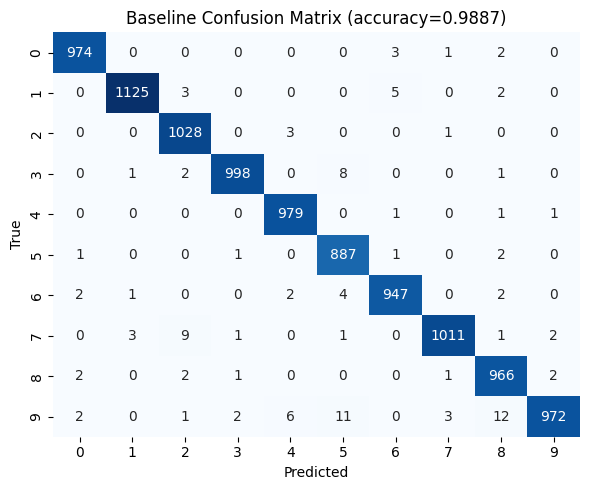

[INFO] Saved confusion matrix -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/images/baseline_confusion.png


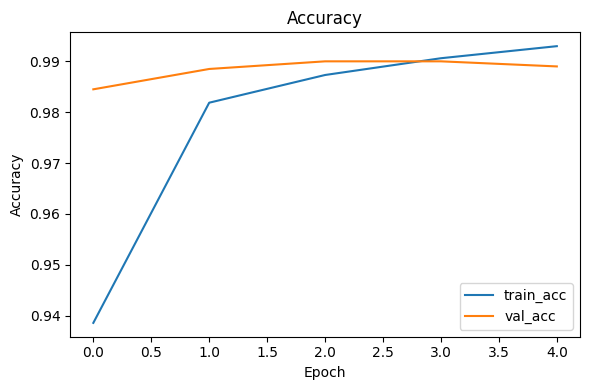

[INFO] Saved accuracy plot -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/images/baseline_accuracy.png


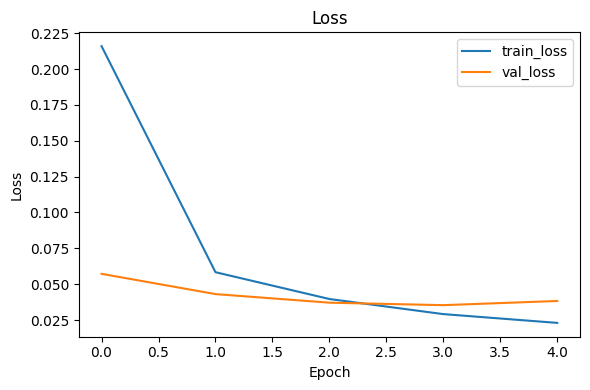

[INFO] Saved loss plot -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/images/baseline_loss.png
[INFO] Saved JSON -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/metrics/baseline_metrics.json


In [5]:
print("\n" + "=" * 70)
print("STEP 1: Load MNIST and train baseline CNN on CLEAN data")
print("=" * 70)

x_train, y_train, x_test, y_test = load_mnist()
print("[INFO] Raw shapes – x_train:", x_train.shape, "x_test:", x_test.shape)
input_shape = x_train.shape[1:]
print("[INFO] Input shape:", input_shape)

baseline_path = MODEL_DIR / "baseline_cnn.keras"

if USE_EXISTING_MODELS and baseline_path.exists():
    model = tf.keras.models.load_model(baseline_path)
    history = None
    train_time = None
    print("[INFO] Loaded existing baseline model from disk.")
else:
    model = build_cnn(input_shape=input_shape)
    t0 = time.time()
    history = model.fit(
        x_train,
        y_train,
        epochs=BASELINE_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=2,
    )
    train_time = time.time() - t0
    model.save(baseline_path)
    print(
        f"[INFO] Trained baseline CNN for {BASELINE_EPOCHS} epochs, "
        f"time = {train_time:.2f} s"
    )
    print(f"[INFO] Saved baseline model -> {baseline_path}")

# Evaluate on CLEAN test set
clean_loss, clean_acc, clean_cm = evaluate_model(model, x_test, y_test)
inf_time = measure_inference_time(model, x_test)

print(f"[RESULT] Baseline – Clean Test Accuracy: {clean_acc:.4f}")
print(f"[RESULT] Baseline – Clean Test Loss:     {clean_loss:.4f}")
print(f"[RESULT] Baseline – Inference time/image: {inf_time:.6f} s")

plot_confusion_matrix(
    clean_cm,
    f"Baseline Confusion Matrix (accuracy={clean_acc:.4f})",
    IMG_DIR / "baseline_confusion.png",
)
plot_history(
    history,
    IMG_DIR / "baseline_accuracy.png",
    IMG_DIR / "baseline_loss.png",
)

baseline_metrics = {
    "scenario": "baseline_clean",
    "loss": clean_loss,
    "accuracy": clean_acc,
    "train_time_seconds": float(train_time) if train_time is not None else None,
    "inference_time_per_image_seconds": inf_time,
    "epochs": BASELINE_EPOCHS,
    "batch_size": BATCH_SIZE,
}
save_json(METRIC_DIR / "baseline_metrics.json", baseline_metrics)

# Task 5 (Method 2): FGSM Attack and Baseline Evaluation



STEP 2: FGSM Adversarial Attack (Red Team) – Method 2
[INFO] Generated FGSM adversarial samples in 2.57 s
[RESULT] Baseline – Clean Acc: 0.9887
[RESULT] Baseline – FGSM  Acc: 0.1469


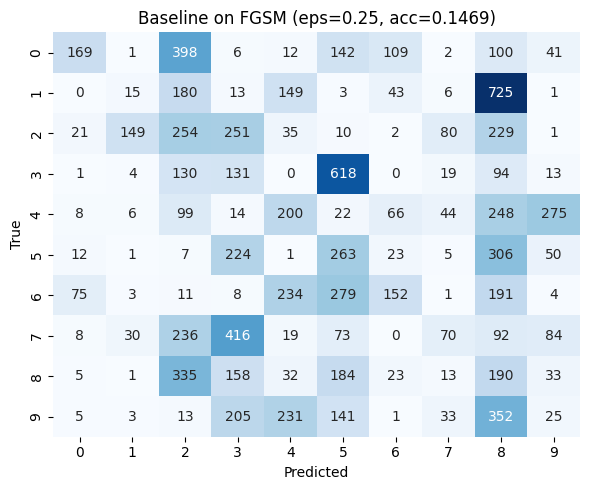

[INFO] Saved confusion matrix -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/images/baseline_fgsm_confusion.png
[INFO] Saved JSON -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/metrics/fgsm_metrics.json


In [6]:
print("\n" + "=" * 70)
print("STEP 2: FGSM Adversarial Attack (Red Team) – Method 2")
print("=" * 70)

classifier = KerasClassifier(model=model, clip_values=(0.0, 1.0), use_logits=False)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=FGSM_EPS)

t0 = time.time()
x_test_adv = attack_fgsm.generate(x=x_test)
fgsm_gen_time = time.time() - t0
print(f"[INFO] Generated FGSM adversarial samples in {fgsm_gen_time:.2f} s")

# Evaluate baseline on CLEAN vs ADV
loss_clean_b, acc_clean_b, _ = evaluate_model(model, x_test, y_test)
loss_adv_b, acc_adv_b, cm_adv = evaluate_model(model, x_test_adv, y_test)

print(f"[RESULT] Baseline – Clean Acc: {acc_clean_b:.4f}")
print(f"[RESULT] Baseline – FGSM  Acc: {acc_adv_b:.4f}")

plot_confusion_matrix(
    cm_adv,
    f"Baseline on FGSM (eps={FGSM_EPS}, acc={acc_adv_b:.4f})",
    IMG_DIR / "baseline_fgsm_confusion.png",
)

fgsm_metrics = {
    "scenario": "baseline_fgsm",
    "attack": "FGSM",
    "eps": FGSM_EPS,
    "generation_time_seconds": fgsm_gen_time,
    "baseline_clean_loss": loss_clean_b,
    "baseline_clean_accuracy": acc_clean_b,
    "baseline_adversarial_loss": loss_adv_b,
    "baseline_adversarial_accuracy": acc_adv_b,
}
save_json(METRIC_DIR / "fgsm_metrics.json", fgsm_metrics)

# Task 7: Adversarial Training (Blue Team)



STEP 3: Adversarial Training (Blue Team)


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Adversarial training completed in 82.27 s over 5 epochs.
[INFO] Saved adversarially trained model -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/models/adv_trained_cnn.keras
[RESULT] Adv-Trained – Clean Acc: 0.9862
[RESULT] Adv-Trained – FGSM  Acc: 0.9848


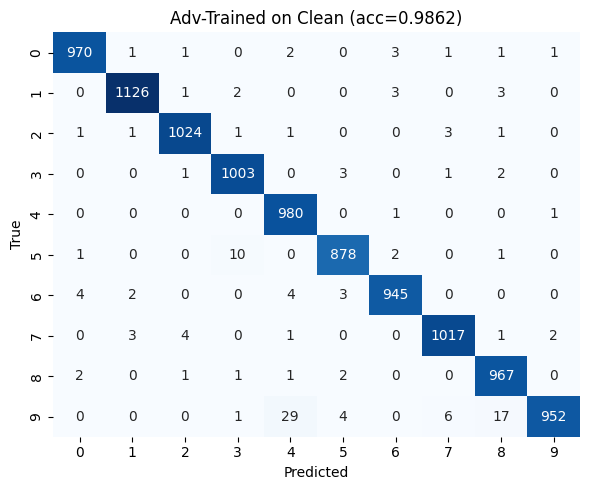

[INFO] Saved confusion matrix -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/images/advtrained_clean_confusion.png


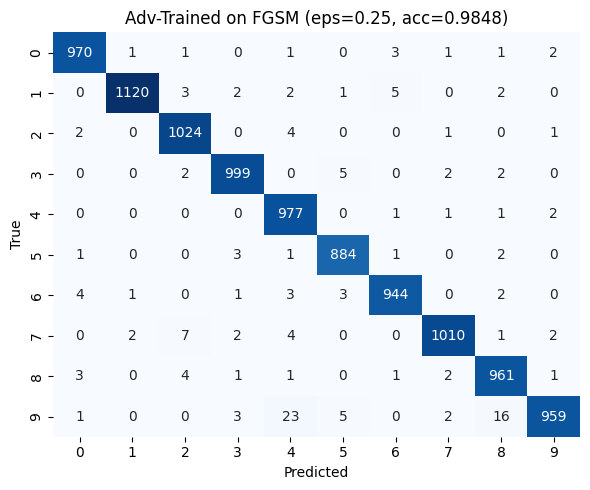

[INFO] Saved confusion matrix -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/images/advtrained_fgsm_confusion.png
[INFO] Saved JSON -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/metrics/advtrain_metrics.json


In [7]:
print("\n" + "=" * 70)
print("STEP 3: Adversarial Training (Blue Team)")
print("=" * 70)

adv_model = tf.keras.models.load_model(baseline_path)  # fresh copy
adv_classifier = KerasClassifier(
    model=adv_model, clip_values=(0.0, 1.0), use_logits=False
)
trainer = AdversarialTrainer(
    classifier=adv_classifier, attacks=attack_fgsm, ratio=0.5
)

t0 = time.time()
trainer.fit(x_train, y_train, nb_epochs=ADV_TRAIN_EPOCHS, batch_size=BATCH_SIZE)
adv_train_time = time.time() - t0
print(
    f"[INFO] Adversarial training completed in {adv_train_time:.2f} s "
    f"over {ADV_TRAIN_EPOCHS} epochs."
)

adv_model_path = MODEL_DIR / "adv_trained_cnn.keras"
adv_model.save(adv_model_path)
print(f"[INFO] Saved adversarially trained model -> {adv_model_path}")

# Evaluate adv-trained model on clean and FGSM data
loss_clean_adv, acc_clean_adv, cm_clean_adv = evaluate_model(
    adv_model, x_test, y_test
)
x_test_adv2 = attack_fgsm.generate(x=x_test)
loss_adv_adv, acc_adv_adv, cm_adv_adv = evaluate_model(
    adv_model, x_test_adv2, y_test
)

print(f"[RESULT] Adv-Trained – Clean Acc: {acc_clean_adv:.4f}")
print(f"[RESULT] Adv-Trained – FGSM  Acc: {acc_adv_adv:.4f}")

plot_confusion_matrix(
    cm_clean_adv,
    f"Adv-Trained on Clean (acc={acc_clean_adv:.4f})",
    IMG_DIR / "advtrained_clean_confusion.png",
)
plot_confusion_matrix(
    cm_adv_adv,
    f"Adv-Trained on FGSM (eps={FGSM_EPS}, acc={acc_adv_adv:.4f})",
    IMG_DIR / "advtrained_fgsm_confusion.png",
)

advtrain_metrics = {
    "scenario": "advtrained_fgsm",
    "attack": "FGSM",
    "eps": FGSM_EPS,
    "advtrain_epochs": ADV_TRAIN_EPOCHS,
    "advtrain_batch_size": BATCH_SIZE,
    "advtrain_time_seconds": adv_train_time,
    "advtrained_clean_loss": loss_clean_adv,
    "advtrained_clean_accuracy": acc_clean_adv,
    "advtrained_adversarial_loss": loss_adv_adv,
    "advtrained_adversarial_accuracy": acc_adv_adv,
}
save_json(METRIC_DIR / "advtrain_metrics.json", advtrain_metrics)

# Task 5 (Method 1): Poisoning via Corner Patch Trigger



STEP 4: Data Poisoning – Corner Patch Trigger (digit '7')
[INFO] Created 100 poisoned training images for digit '7'.
Epoch 1/5
422/422 - 6s - 13ms/step - accuracy: 0.9371 - loss: 0.2149 - val_accuracy: 0.9840 - val_loss: 0.0634
Epoch 2/5
422/422 - 5s - 12ms/step - accuracy: 0.9815 - loss: 0.0601 - val_accuracy: 0.9883 - val_loss: 0.0462
Epoch 3/5
422/422 - 5s - 12ms/step - accuracy: 0.9872 - loss: 0.0414 - val_accuracy: 0.9890 - val_loss: 0.0402
Epoch 4/5
422/422 - 5s - 12ms/step - accuracy: 0.9905 - loss: 0.0309 - val_accuracy: 0.9902 - val_loss: 0.0378
Epoch 5/5
422/422 - 5s - 12ms/step - accuracy: 0.9927 - loss: 0.0236 - val_accuracy: 0.9893 - val_loss: 0.0392
[INFO] Trained poisoned model in 25.70 s -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/models/poisoned_cnn.keras
[RESULT] Poisoned-Train – Clean Test Acc: 0.9896


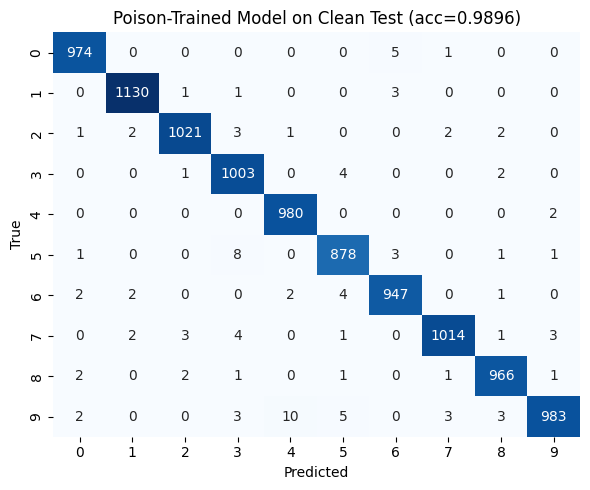

[INFO] Saved confusion matrix -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/images/poison_clean_confusion.png
[RESULT] Target digit 7 – Clean Acc:   0.9864
[RESULT] Target digit 7 – Patched Acc: 0.9864


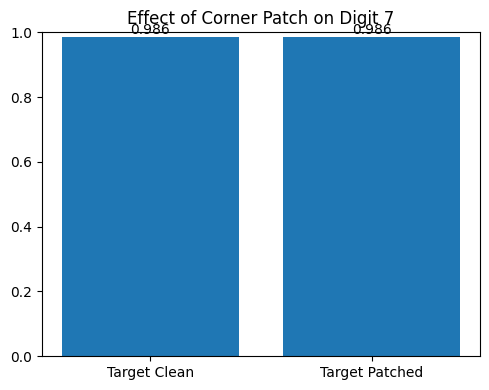

[INFO] Saved poison target effect graph -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/images/poison_target_effect.png
[INFO] Saved JSON -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/metrics/poison_metrics.json


In [8]:
# === Task 5 (Method 1): Poisoning via Corner Patch Trigger ===
print("\n" + "=" * 70)
print("STEP 4: Data Poisoning – Corner Patch Trigger (digit '7')")
print("=" * 70)

# 1) Build poisoned train set
poison_imgs, poison_lbls, poison_idx = create_poisoned_dataset(
    x_train,
    y_train,
    target_class=TARGET_CLASS,
    num_poison=100,
    patch_size=PATCH_SIZE,
    patch_value=PATCH_VALUE,
)
print(f"[INFO] Created {len(poison_imgs)} poisoned training images for digit '{TARGET_CLASS}'.")

x_train_poisoned = x_train.copy()
x_train_poisoned[poison_idx] = poison_imgs
y_train_poisoned = y_train.copy()

# 2) Train poisoned model
poison_model = build_cnn(input_shape=input_shape)
t0 = time.time()
poison_history = poison_model.fit(
    x_train_poisoned,
    y_train_poisoned,
    epochs=POISON_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=2,
)
poison_train_time = time.time() - t0
poison_model_path = MODEL_DIR / "poisoned_cnn.keras"
poison_model.save(poison_model_path)
print(f"[INFO] Trained poisoned model in {poison_train_time:.2f} s -> {poison_model_path}")

# 3) Evaluate on full clean test
poison_clean_loss, poison_clean_acc, poison_clean_cm = evaluate_model(
    poison_model, x_test, y_test
)
print(f"[RESULT] Poisoned-Train – Clean Test Acc: {poison_clean_acc:.4f}")
plot_confusion_matrix(
    poison_clean_cm,
    f"Poison-Trained Model on Clean Test (acc={poison_clean_acc:.4f})",
    IMG_DIR / "poison_clean_confusion.png",
)

# 4) Compute trigger effect for TARGET_CLASS and plot
target_test_idx = np.where(y_test == TARGET_CLASS)[0]
x_target_clean = x_test[target_test_idx]
x_target_patched = np.array(
    [add_corner_patch(img, size=PATCH_SIZE, value=PATCH_VALUE) for img in x_target_clean]
)

y_pred_target_clean = np.argmax(poison_model.predict(x_target_clean,  verbose=0), axis=1)
y_pred_target_patched = np.argmax(poison_model.predict(x_target_patched, verbose=0), axis=1)

acc_target_clean   = float(np.mean(y_pred_target_clean   == y_test[target_test_idx]))
acc_target_patched = float(np.mean(y_pred_target_patched == y_test[target_test_idx]))

print(
    f"[RESULT] Target digit {TARGET_CLASS} – Clean Acc:   {acc_target_clean:.4f}\n"
    f"[RESULT] Target digit {TARGET_CLASS} – Patched Acc: {acc_target_patched:.4f}"
)

fig, ax = plt.subplots(figsize=(5, 4))
labels = ["Target Clean", "Target Patched"]
vals   = [acc_target_clean, acc_target_patched]
ax.bar(range(len(labels)), vals)
ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels)
ax.set_ylim(0, 1.0)
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f"{v:.3f}", ha="center")
ax.set_title(f"Effect of Corner Patch on Digit {TARGET_CLASS}")
fig.tight_layout()
fig.savefig(IMG_DIR / "poison_target_effect.png", bbox_inches="tight")
plt.show(); plt.close(fig)
print(f"[INFO] Saved poison target effect graph -> {IMG_DIR / 'poison_target_effect.png'}")

# 5) Save metrics
poison_metrics = {
    "scenario": "poison_corner_patch",
    "mode": "feature",
    "target_class": TARGET_CLASS,
    "num_poisoned": int(len(poison_imgs)),
    "patch_size": PATCH_SIZE,
    "patch_value": PATCH_VALUE,
    "epochs": POISON_EPOCHS,
    "batch_size": BATCH_SIZE,
    "train_time_seconds": poison_train_time,
    "clean_test_loss": poison_clean_loss,
    "clean_test_accuracy": poison_clean_acc,
    "target_class_clean_accuracy": acc_target_clean,
    "target_class_patched_accuracy": acc_target_patched,
}
save_json(METRIC_DIR / "poison_metrics.json", poison_metrics)


# Accuracy Comparison (Baseline vs Adv-Trained)


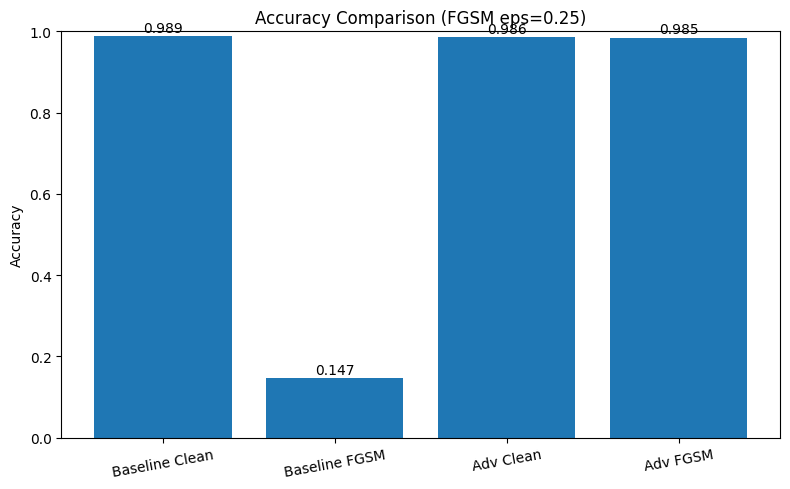

[INFO] Saved accuracy comparison graph -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/images/fgsm_accuracy_comparison.png


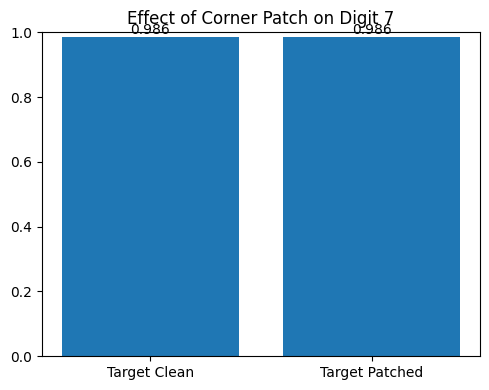

[INFO] Saved poison target effect graph -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/images/poison_target_effect.png
[INFO] Saved JSON -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/metrics/poison_metrics.json


In [9]:
labels = ["Baseline Clean", "Baseline FGSM", "Adv Clean", "Adv FGSM"]
values = [acc_clean_b, acc_adv_b, acc_clean_adv, acc_adv_adv]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(len(labels)), values)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=10)
ax.set_ylim(0, 1.0)
ax.set_ylabel("Accuracy")
ax.set_title(f"Accuracy Comparison (FGSM eps={FGSM_EPS})")
for i, v in enumerate(values):
    ax.text(i, v + 0.01, f"{v:.3f}", ha="center")
fig.tight_layout()
fig.savefig(IMG_DIR / "fgsm_accuracy_comparison.png", bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"[INFO] Saved accuracy comparison graph -> {IMG_DIR / 'fgsm_accuracy_comparison.png'}")

# Bar chart to show trigger impact
fig, ax = plt.subplots(figsize=(5, 4))
labels = ["Target Clean", "Target Patched"]
vals = [acc_target_clean, acc_target_patched]
ax.bar(range(len(labels)), vals)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.0)
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f"{v:.3f}", ha="center")
ax.set_title(f"Effect of Corner Patch on Digit {TARGET_CLASS}")
fig.tight_layout()
fig.savefig(IMG_DIR / "poison_target_effect.png", bbox_inches="tight")
plt.show()
plt.close(fig)
print(f"[INFO] Saved poison target effect graph -> {IMG_DIR / 'poison_target_effect.png'}")

poison_metrics = {
    "scenario": "poison_corner_patch",
    "mode": "feature",
    "target_class": TARGET_CLASS,
    "num_poisoned": int(len(poison_imgs)),
    "patch_size": PATCH_SIZE,
    "patch_value": PATCH_VALUE,
    "epochs": POISON_EPOCHS,
    "batch_size": BATCH_SIZE,
    "train_time_seconds": poison_train_time,
    "clean_test_loss": poison_clean_loss,
    "clean_test_accuracy": poison_clean_acc,
    "target_class_clean_accuracy": acc_target_clean,
    "target_class_patched_accuracy": acc_target_patched,
}
save_json(METRIC_DIR / "poison_metrics.json", poison_metrics)

# Metrics Summary (JSON Only)

In [ ]:
print("\n" + "=" * 70)
print("STEP 5: Aggregate metrics (for your report)")
print("=" * 70)

summary = aggregate_metrics(
    {
        "baseline": METRIC_DIR / "baseline_metrics.json",
        "fgsm": METRIC_DIR / "fgsm_metrics.json",
        "advtrain": METRIC_DIR / "advtrain_metrics.json",
        "poison": METRIC_DIR / "poison_metrics.json",
    }
)
save_json(METRIC_DIR / "metrics_summary.json", summary)

print(json.dumps(summary, indent=2))
print("\n[INFO] All metrics saved under:", METRIC_DIR)
print("[INFO] All plots saved under:", IMG_DIR)
print("\nNOTE:")
print("  • Task 3 (STRIDE threat modeling) and Task 4 (SAST) should be")
print("    handled in your written report / separate tool run (e.g., Bandit).")


STEP 5: Aggregate metrics (for your report)
[INFO] Saved JSON -> /Users/kartekeyaan/Chonky_folder/Security_MNIST_project/secure_ai_outputs/metrics/metrics_summary.json
{
  "baseline": {
    "scenario": "baseline_clean",
    "loss": 0.03542975336313248,
    "accuracy": 0.9886999726295471,
    "train_time_seconds": 22.283465147018433,
    "inference_time_per_image_seconds": 3.262028694152832e-05,
    "epochs": 5,
    "batch_size": 128
  },
  "fgsm": {
    "scenario": "baseline_fgsm",
    "attack": "FGSM",
    "eps": 0.25,
    "generation_time_seconds": 2.5684590339660645,
    "baseline_clean_loss": 0.03542975336313248,
    "baseline_clean_accuracy": 0.9886999726295471,
    "baseline_adversarial_loss": 4.647155284881592,
    "baseline_adversarial_accuracy": 0.1468999981880188
  },
  "advtrain": {
    "scenario": "advtrained_fgsm",
    "attack": "FGSM",
    "eps": 0.25,
    "advtrain_epochs": 5,
    "advtrain_batch_size": 128,
    "advtrain_time_seconds": 82.2701768875122,
    "advtrained

# SAST demo (pickle vs JSON)

In [ ]:
# Keep the unsafe path OFF by default. Turn it on only to demonstrate Bandit.
def load_cache_untrusted_pickle(pickle_path: str):
    p = Path(pickle_path); p.parent.mkdir(parents=True, exist_ok=True)
    if not p.exists():
        with open(p, "wb") as f:
            pickle.dump({"note":"demo cache created","version":1}, f)  # B301
    with open(p, "rb") as f:
        return pickle.load(f)  # B301

def load_cache_json_safe(json_path: str):
    p = Path(json_path); p.parent.mkdir(parents=True, exist_ok=True)
    if not p.exists():
        p.write_text(json.dumps({"note":"demo cache created (json)","version":1}), encoding="utf-8")
    return json.loads(p.read_text(encoding="utf-8"))

use_unsafe = os.getenv("ALLOW_UNSAFE_PICKLE", "0") == "1"
if use_unsafe:
    cache = load_cache_untrusted_pickle("reports/tmp_cache.pkl")
    print("[SAST-DEMO] UNSAFE pickle cache keys:", list(cache.keys()))
else:
    cache = load_cache_json_safe("reports/tmp_cache.json")
    print("[SAST-DEMO] SAFE json cache keys:", list(cache.keys()))


[SAST-DEMO] SAFE json cache keys: ['note', 'version']


In [ ]:
summary_path = METRIC_DIR / "metrics_summary.json"
print("Summary exists:", summary_path.exists())
print("Images count:", len(list(IMG_DIR.glob("*.png"))))

Summary exists: True
Images count: 9
